In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import PCA

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive


from numpyro.handlers import trace, seed
from utils import *

/Users/salati/miniforge3/envs/numpyro2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load dataset
scData = pd.read_csv("data/190923_Neuron_1.csv")
scData = scData.T
col_names = scData.iloc[0, :].values
# delete first row

scData = scData.drop(scData.index[0])
scData.columns = col_names
scData["Vip"].mean()

# create anndata object
E_sc = anndata.AnnData(scData)
E_sc.X = E_sc.X.astype(float)


In [5]:
# take the index of scData it's a list of strings
# split every string by '_' and take the first element, fro the first element remove lettter X
# and then convert to int
# this is the sample index
sample_index = np.array(
    [int(s.split("_")[0][1:]) for s in E_sc.obs.index.values.tolist()]
)
sample_index

array([14, 14, 14, ..., 58, 58, 58])

In [6]:
# remove columns/genes with all zeros
E_sc = E_sc[:, E_sc.X.sum(axis=0) != 0]
# normalize per cell
E_sc.layers["norm"] = E_sc.X / E_sc.X.sum(axis=1).reshape(-1, 1)
# now standardize the data
E_sc.layers["stand"] = (
    E_sc.layers["norm"] - E_sc.layers["norm"].mean(axis=0)
) / E_sc.layers["norm"].std(axis=0)
E_sc.obs["counts"] = E_sc.X.sum(axis=1)


In [7]:
# load the fitted coef
coef_2D = pd.read_csv(
    "fit/theta_2D.csv",
)
zonated_genes = coef_2D["Unnamed: 0"].values
theta2 = coef_2D.values[:, 1:]
theta2


array([[-0.1060528035695116, 1.5169714079160126, -2.114569256294606,
        0.9817383062072575, -6.186548418594548],
       [-0.0822100952110984, -0.2786755261823923, -0.042205301863912,
        -0.1048808816330125, -7.957423669488906],
       [-0.3759333412816059, -0.1285280458899957, -0.5472159724300133,
        0.9050549913649238, -8.025798594240142],
       [-0.1286309004166568, -0.5225452219918766, 0.2904068128935288,
        0.3934424801652917, -9.140114559119224],
       [-0.1747519982860119, 0.0176377821591505, -0.3453440493310855,
        -0.2589218334369285, -7.610982586096162],
       [-0.2288972842438667, -0.1092643542254583, -0.116831337878491,
        0.6830376225547695, -10.752939062220864],
       [0.0974627423999575, 0.484734375724442, -0.8615520464205434,
        -1.3479905531405616, -9.67834851642704],
       [-0.3180058052660655, 0.2036318305859503, -1.3349114010802894,
        1.7150086203016943, -9.457233192575528],
       [-0.0577281339566127, -0.341890976533231

In [8]:
sc_zon = zonated_genes[zonated_genes != "Prokr2"]
sc_small = E_sc[:, sc_zon]

NC, NG = sc_small.shape

In [9]:
sc_small.layers["norm"].astype(float)
corr_cells = np.corrcoef(sc_small.layers["norm"].astype(float))
corr_genes = np.corrcoef(sc_small.layers["norm"].astype(float).T)


/Users/salati/miniforge3/envs/numpyro2/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/salati/miniforge3/envs/numpyro2/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [10]:
# # set the diagonal to 0
# np.fill_diagonal(corr_genes, 0)

# # plott correlation matrix, plot the names of the genes on the axis and the colorbar
# plt.imshow(corr_genes, cmap="bwr", vmin=-1, vmax=1)
# plt.colorbar()
# plt.xticks(np.arange(len(sc_zon)), sc_zon, rotation=90)
# plt.yticks(np.arange(len(sc_zon)), sc_zon)
# plt.show()


## finding seed values for x,y,z

In [11]:
zonated_counts = sc_small.X.sum(axis=1)
mask_zc = zonated_counts == 0
print(mask_zc.sum())
# now remove cells that have zeros in all zonated genes
sc_small = sc_small[~mask_zc, :]


453


In [12]:
sc_small

View of AnnData object with n_obs × n_vars = 3020 × 9
    obs: 'counts'
    layers: 'norm', 'stand'

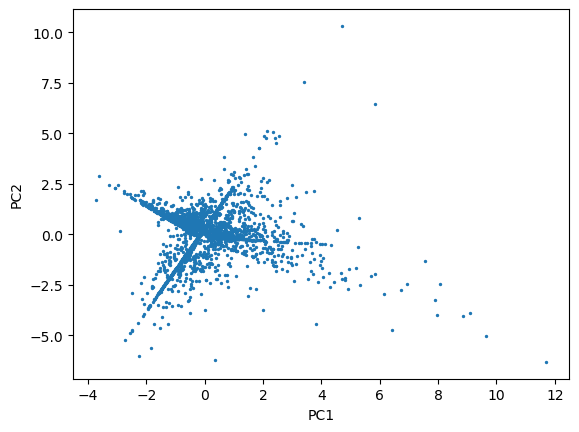

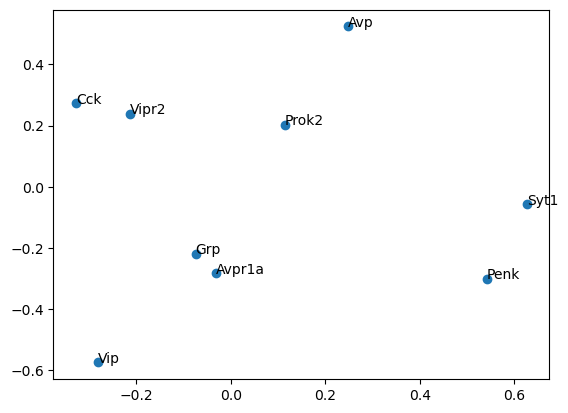

In [13]:
# perform PCA and plot the first 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(sc_small.layers["stand"])
vec = pca.components_

# plot the first 2 components
plt.scatter(PC[:, 0], PC[:, 1], s=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# plot the loadings of the first 2 components
plt.scatter(vec[0, :], vec[1, :])
# now annotate with gene names
for i, g in enumerate(sc_zon):
    plt.annotate(g, (vec[0, i], vec[1, i]))


In [14]:
# print mean, and variance for the normalized cut of every gene, next to the gene name
for i, g in enumerate(sc_zon):
    print(g, sc_small[:, g].layers["norm"].mean(), sc_small[:, g].layers["norm"].var())

Vip 0.004168980557466908 0.00011980215386873495
Avp 0.005590197995291927 0.00017522252690295903
Prok2 6.602918039254667e-05 1.8395181801524485e-07
Penk 0.0002131344766732339 9.068027370466524e-07
Vipr2 0.0005376401553992967 9.36010444886659e-07
Avpr1a 4.151496475663759e-05 7.345211199322207e-08
Cck 0.0009145474225289935 6.680407061961441e-06
Grp 7.037686005509476e-05 3.2640422869857734e-07
Syt1 0.0005722104146576337 1.375506479785902e-06


## trying to order cells

In [15]:
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]))
np.argsort(sc_small[:, "Penk"].layers["norm"].squeeze()).sum()

array(4558690)

In [16]:
# now take gene Penk and get the argsort. This will give the order of the cells
# after standardize this position vecotr

# get the order of the cells
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]).squeeze())
z_guess = (order_z - order_z.mean()) / order_z.std()
order_z

# do the same for gene Vip
order_y = np.argsort(np.argsort(sc_small[:, "Vip"].layers["norm"]).squeeze())
y_guess = (order_y - order_y.mean()) / order_y.std()
order_y


ArrayView([   0, 2008, 2009, ..., 1011, 1002, 3019])

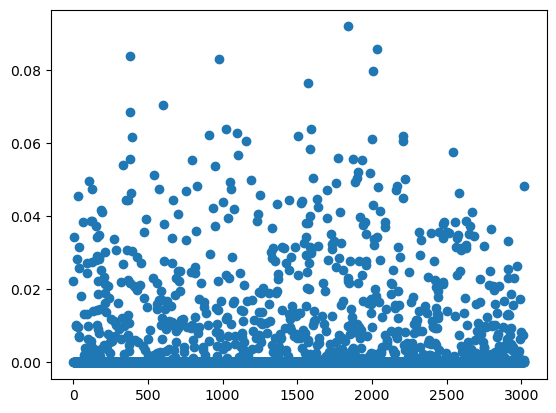

In [17]:
# plt.scatter(np.linspace(0 , 1, NC), sc_small[:, 'Penk'].layers['norm'])
plt.scatter(order_y, sc_small[:, "Vip"].layers["norm"])


## JAX

In [18]:
sc_counts = jnp.array(sc_small.obs["counts"].values)
Y = jnp.array(sc_small[:, :].layers["norm"])
Y_counts = jnp.array(sc_small[:, :].X)
Y_standard = jnp.array(sc_small[:, "Vip"].layers["norm"])
Y_standard = (Y_standard - Y_standard.mean()) / Y_standard.std()


theta2 = jnp.array(theta2.astype(float))
sc_counts.dtype


dtype('float32')

In [19]:
Y_counts.max()
jnp.log(110)

DeviceArray(4.7004805, dtype=float32, weak_type=True)

In [20]:
# lea tensors, these are the vectors that we want to optimize
X = np.stack((y_guess, z_guess), axis=-1)
# alternative, fully random initialization
# convert onated dataset to tesor

dimension of tensor :
- X = NC x N_dim  
- theta = Ng x Nparam

In [52]:
def model_2D(theta, n_counts, y=None):
    Nc = y.shape[0]
    Ng = y.shape[1]

    cell_plate = numpyro.plate("cells", size=Nc, dim=-2)
    gene_plate = numpyro.plate("genes", size=Ng, dim=-1)

    disp = numpyro.param(
        "disp",
        jnp.array(0.3),
        constraint=dist.constraints.positive,
    )

    with cell_plate:
        x_1 = numpyro.sample("x_1", dist.Normal(0.0, 1))
        x_2 = numpyro.sample("x_2", dist.Normal(0.0, 1))
    
    lmbda = (
        theta[:, 0][None, :] * x_1**2
        + theta[:, 1][None, :] * x_1
        + theta[:, 2][None, :] * x_2**2
        + theta[:, 3][None, :] * x_2
        + theta[:, 4][None, :]
    )
    #before taking the exp i want to avoid exploding values
    lmbda = jnp.clip(lmbda, a_min=-10, a_max=10)
    mu = jnp.exp(lmbda) * n_counts[:, None]

    ##Using the mean and dispersion parametrization
    conc = 1 / disp
    rate = 1 / (disp * mu)

    with cell_plate, gene_plate:
        numpyro.sample("obs_", dist.GammaPoisson(concentration=conc, rate=rate), obs=y)


trace(seed(model_2D, random.PRNGKey(0))).get_trace(theta2, sc_counts, y=Y_counts);


In [53]:
# now a guide for the model_2D

def guide_2D(theta, n_counts, y=None):
    # define the plates
    Nc = y.shape[0]

    cell_plate = numpyro.plate("cells", size=Nc, dim=-2)

    # define the parameters
    x_1_loc = numpyro.param("x_1_loc", jnp.zeros(Nc).reshape(-1, 1))
    x_2_loc = numpyro.param("x_2_loc", jnp.zeros(Nc).reshape(-1, 1))

    x_1_scale = numpyro.param(
        "x_1_scale",
        0.1 * jnp.ones(Nc).reshape(-1, 1),
        constraint=dist.constraints.positive,
    )
    
    x_2_scale = numpyro.param(
        "x_2_scale",
        0.1 * jnp.ones(Nc).reshape(-1, 1),
        constraint=dist.constraints.positive,
    )

    with cell_plate:
        x_1 = numpyro.sample("x_1", dist.Normal(x_1_loc, x_1_scale))
        x_2 = numpyro.sample("x_2", dist.Normal(x_2_loc, x_2_scale))


trace(seed(guide_2D, random.PRNGKey(0))).get_trace(theta2, sc_counts, y=Y_counts);

In [54]:
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model_2D, guide_2D, optimizer, loss=Trace_ELBO())
#svi = SVI(model_2D_batch, guide_2D_batch, optimizer, loss=Trace_ELBO())
result = svi.run(random.PRNGKey(0), 2000, theta2, sc_counts, y=Y_counts)

100%|██████████| 2000/2000 [00:08<00:00, 226.18it/s, init loss: 69928.2891, avg. loss [1901-2000]: 34672.3164]


loss: 34276.08984375
1.7711711


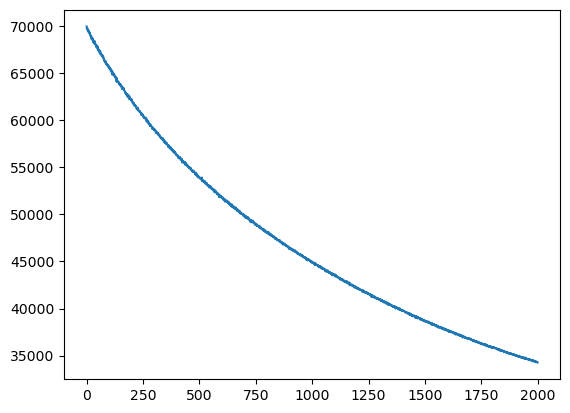

In [55]:
result.losses

plt.plot(result.losses)
print("loss: {}".format(result.losses[-1]))
print(result.params['disp'])

Text(0, 0.5, 'std')

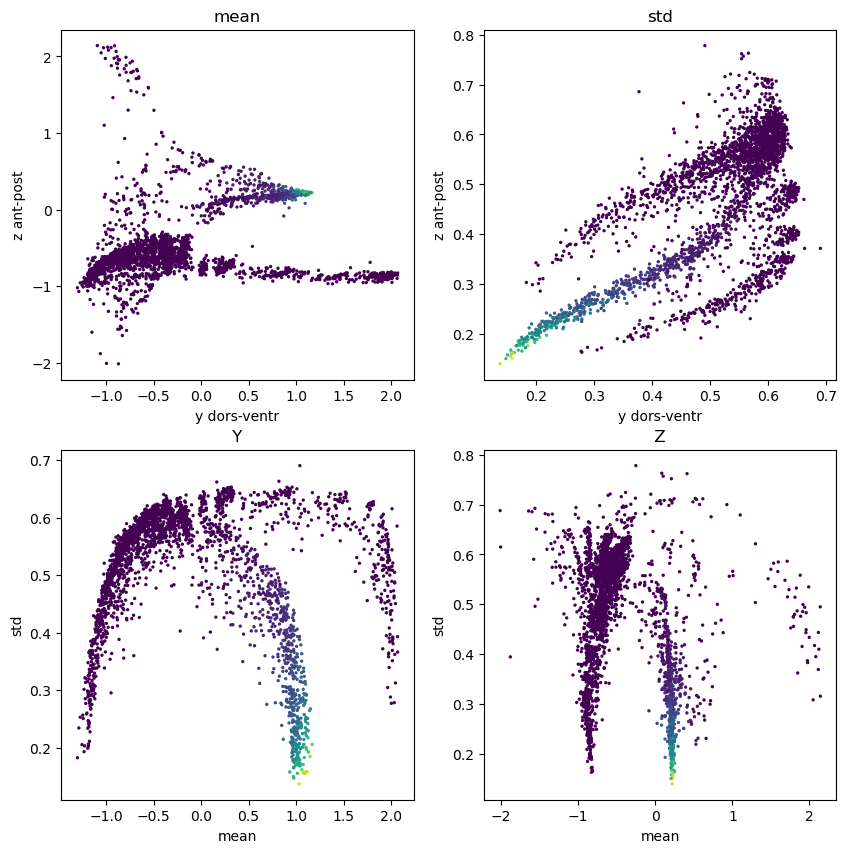

In [56]:
gene= 'Vip'

x_1 = np.array(result.params["x_1_loc"]).squeeze()
x_2 = np.array(result.params["x_2_loc"]).squeeze()
x_train = np.stack((x_1, x_2), axis=-1)
sigma_1 = np.array(result.params["x_1_scale"]).squeeze()
sigma_2 = np.array(result.params["x_2_scale"]).squeeze()
sigma_train = np.stack((sigma_1, sigma_2), axis=-1)

#start quadruple plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(x_train[:, 0], x_train[:, 1],  c=sc_small[:, gene].layers["norm"].squeeze(), s=2)
axs[0, 0].set_title("mean")
axs[0, 0].set_xlabel("y dors-ventr")
axs[0, 0].set_ylabel("z ant-post")

axs[0, 1].scatter(sigma_train[:, 0], sigma_train[:, 1],  c=sc_small[:, gene].layers["norm"].squeeze(), s=2)
axs[0, 1].set_title("std")
axs[0, 1].set_xlabel("y dors-ventr")
axs[0, 1].set_ylabel("z ant-post")

axs[1, 0].scatter(x_train[:, 0], sigma_train[:, 0],  c=sc_small[:, gene].layers["norm"].squeeze(), s=2)
axs[1, 0].set_title(" Y ")
axs[1, 0].set_xlabel("mean")
axs[1, 0].set_ylabel("std")

axs[1, 1].scatter(x_train[:, 1], sigma_train[:, 1],  c=sc_small[:, gene].layers["norm"].squeeze(), s=2)
axs[1, 1].set_title(" Z ")
axs[1, 1].set_xlabel("mean")
axs[1, 1].set_ylabel("std")


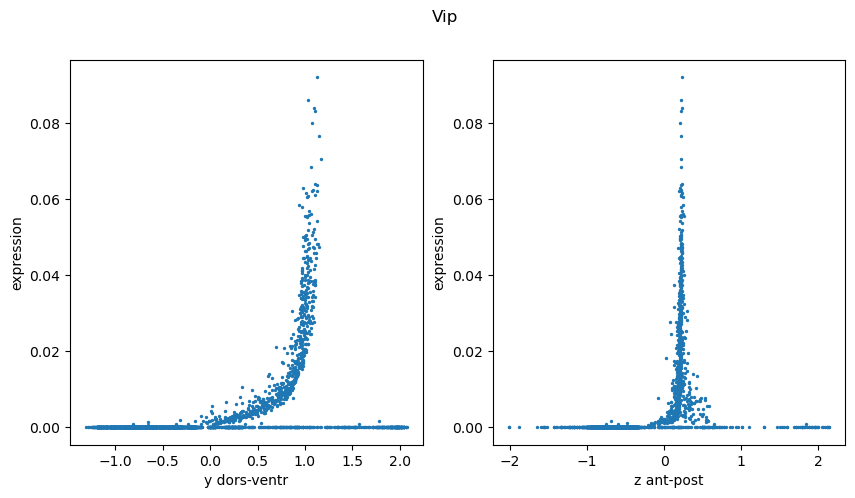

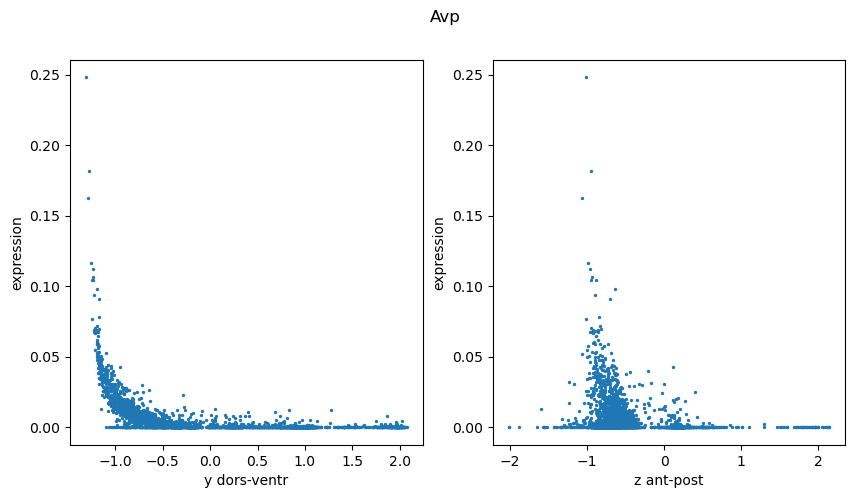

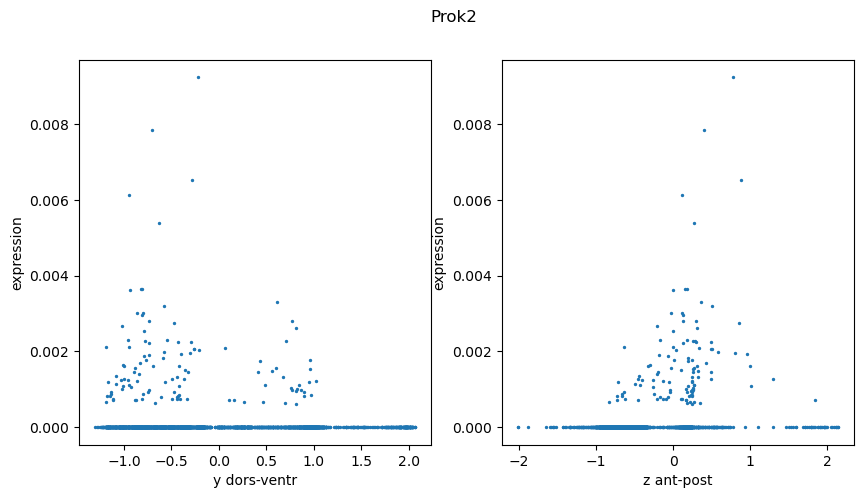

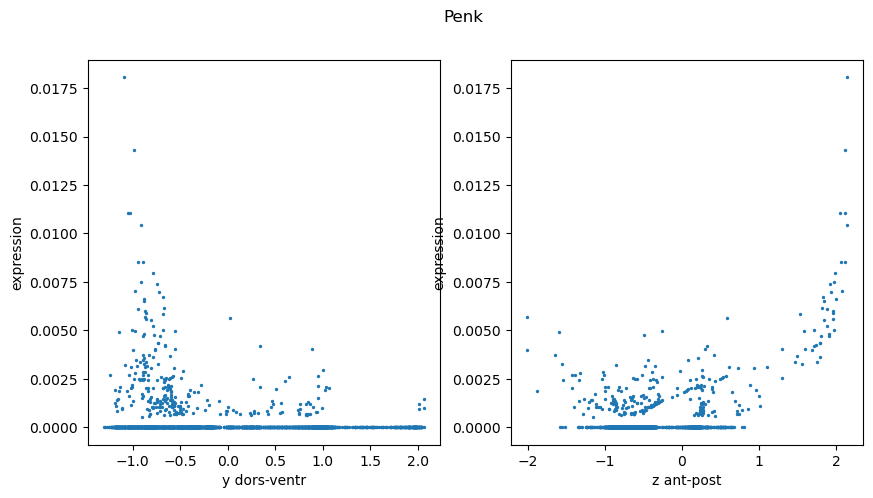

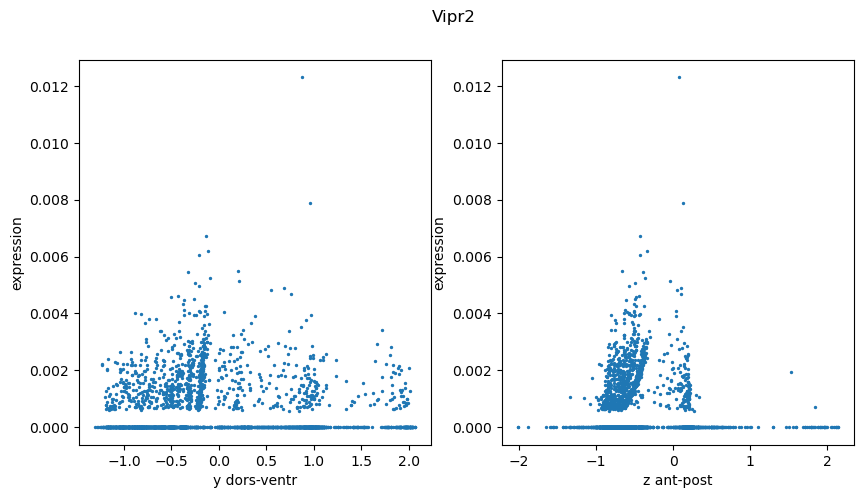

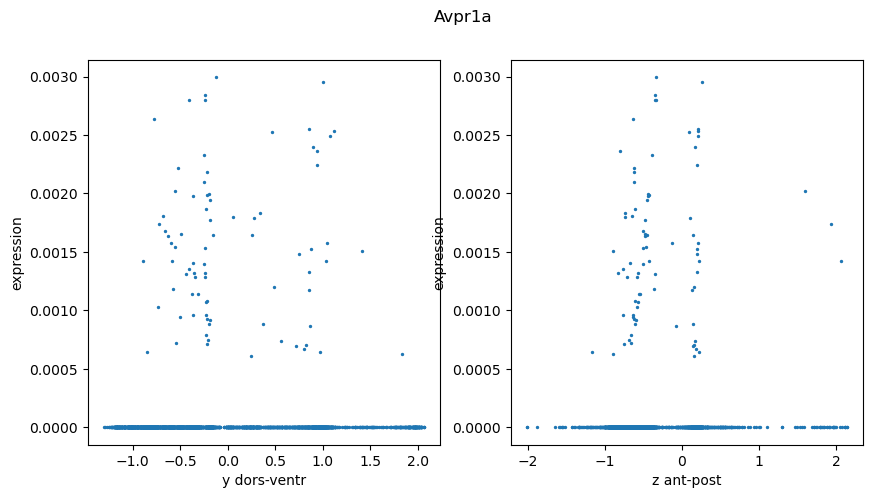

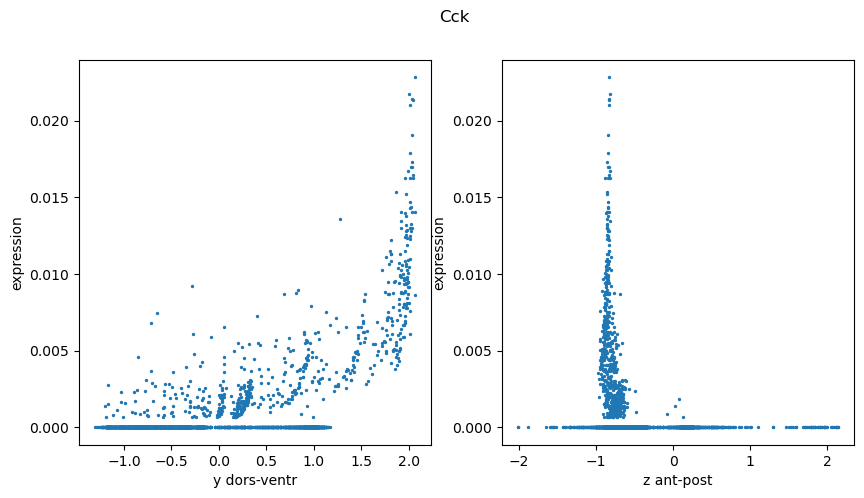

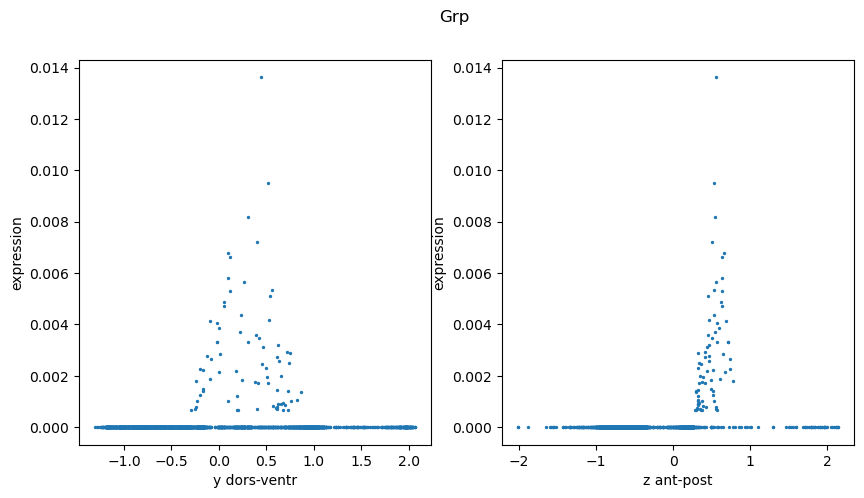

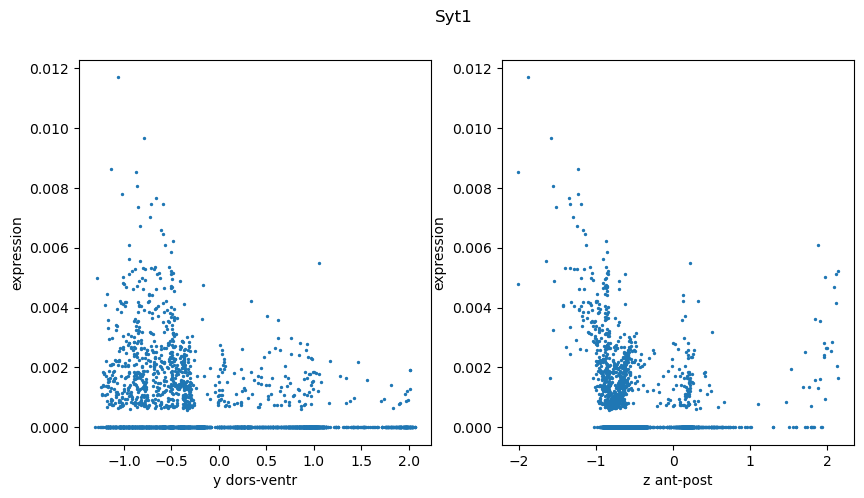

In [57]:
for i, g in enumerate(sc_zon):
    plt.figure(figsize=(10, 5))
    plt.suptitle(g)
    plt.subplot(1, 2, 1)
    plt.scatter(x_train[:, 0], sc_small[:, g].layers["norm"], s=2)
    plt.xlabel("y dors-ventr")
    plt.ylabel("expression")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:, 1], sc_small[:, g].layers["norm"], s=2)
    plt.xlabel("z ant-post")
    plt.ylabel("expression")

    plt.show()


In [ ]:
# def model_2D_gaussian(theta, y=None):
#     Nc = y.shape[0]
#     Ng = y.shape[1]

#     cell_plate = numpyro.plate("cells", size=Nc, dim=-2)
#     gene_plate = numpyro.plate("genes", size=Ng, dim=-1)

#     disp = numpyro.sample("disp", dist.Uniform(-2.0, 2.0))

#     with cell_plate:
#             x_1 = numpyro.sample("x_1", dist.Normal(0., 2.0))

#     with cell_plate:
#         x_2 = numpyro.sample("x_2", dist.Normal(0., 2.0))

#     lmbda = (
#         theta[:, 0][None, :] * x_1[:, None] ** 2
#         + theta[:, 1][None, :] * x_1[:, None]
#         + theta[:, 2][None, :] * x_2[:, None] ** 2
#         + theta[:, 3][None, :] * x_2[:, None]
#         + theta[:, 4][None, :]
#     )

#     alpha = jnp.exp(disp)
#     mu = jnp.exp(lmbda)
#     ##Using the mean and dispersion parametrization

#     with cell_plate, gene_plate:
#         numpyro.sample("obs", dist.Normal(loc = mu, scale = 1) , obs=y)

# model_2D(theta2, sc_counts, y=Y)

# phases

In [68]:
# load daset
time = pd.read_csv("data/190923_Neuron_1_metadata.csv")
time = time.iloc[~mask_zc, :]
print(time.shape)
time.head()


(3020, 5)


,Unnamed: 0,phase_hr_mod,phase_inf,labels,cell_barcode
0,1,14,23.291099,14,14_AAAAGGGGCCGT
1,2,14,18.018134,14,14_AAAGCGCGCTAA
2,3,14,15.120667,14,14_AAATCATGTGTA
4,5,14,17.767185,14,14_AACCTTCCCAGG
5,6,14,18.794643,14,14_AAGAGCGGTCGA


In [77]:
labels = time['labels'].values
phase_inf = time['phase_inf'].values

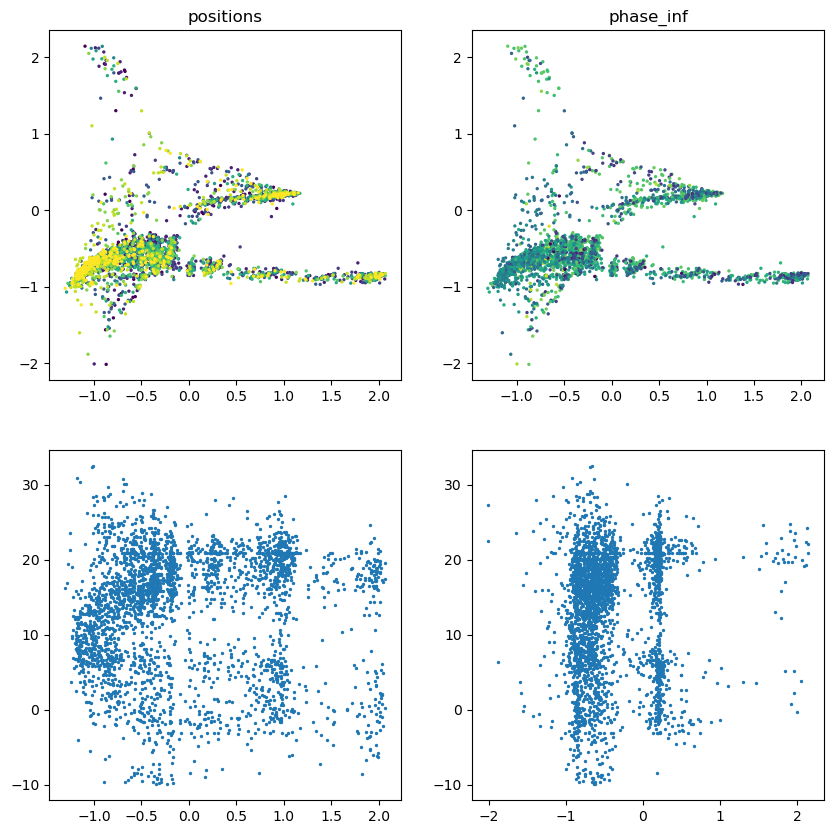

In [93]:
# quadruple plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(x_train[:, 0], x_train[:, 1],  c=labels, s=2)
axs[0, 0].set_title("positions")

axs[0, 1].scatter(x_train[:, 0], x_train[:, 1],  c=phase_inf, s=2)
axs[0, 1].set_title("phase_inf")

axs[1, 0].scatter(x_train[:, 0], phase_inf, s=2)
axs[1, 1].scatter(x_train[:, 1], phase_inf, s=2)


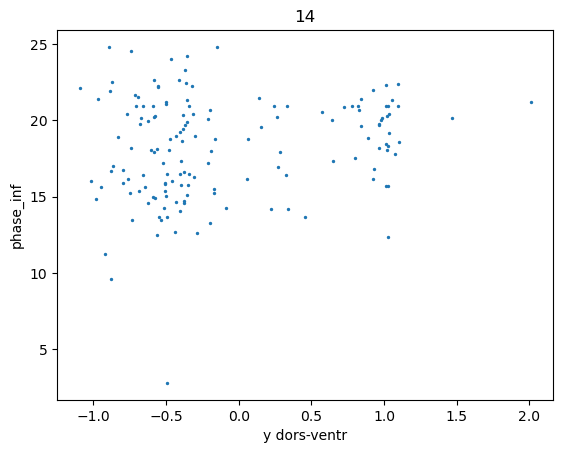

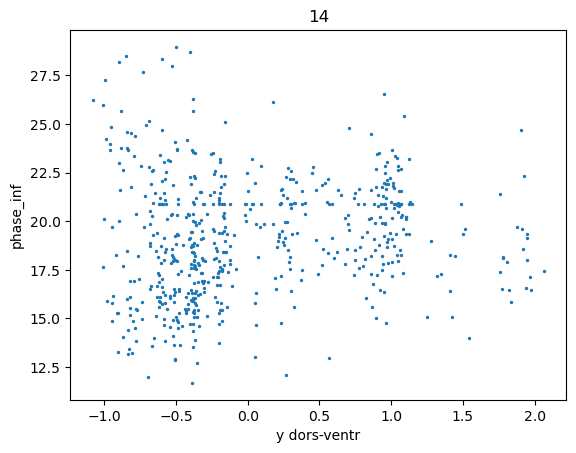

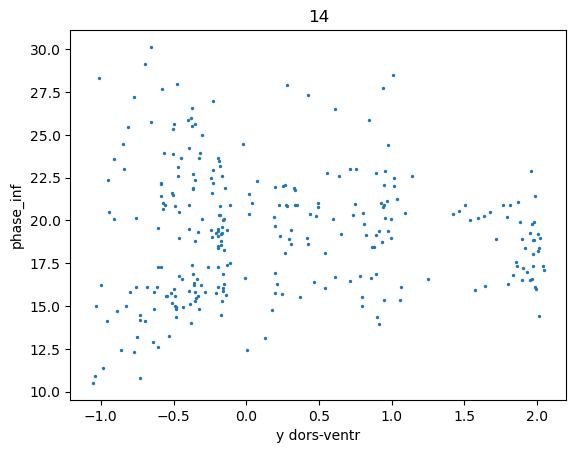

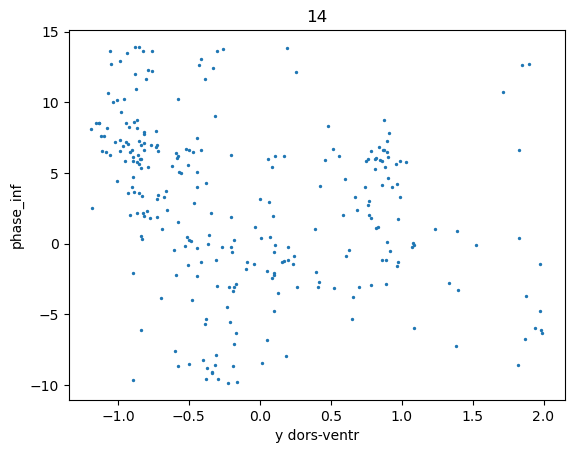

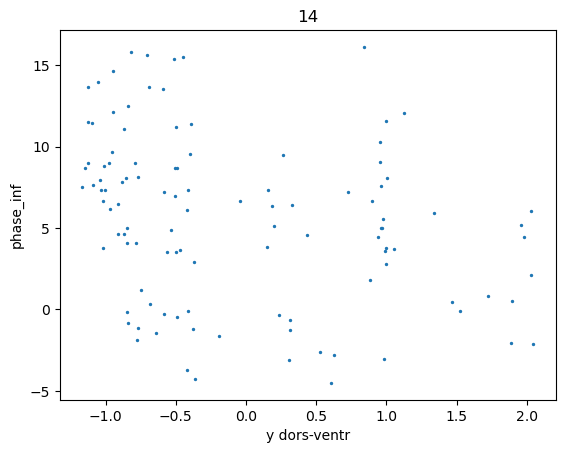

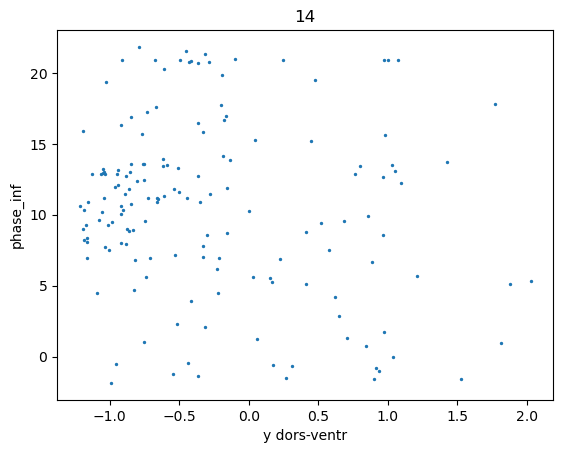

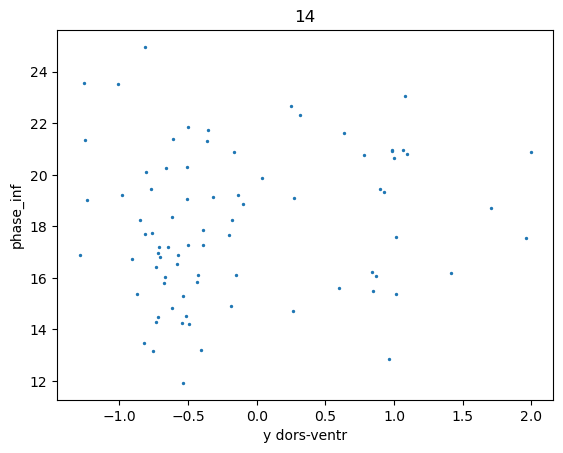

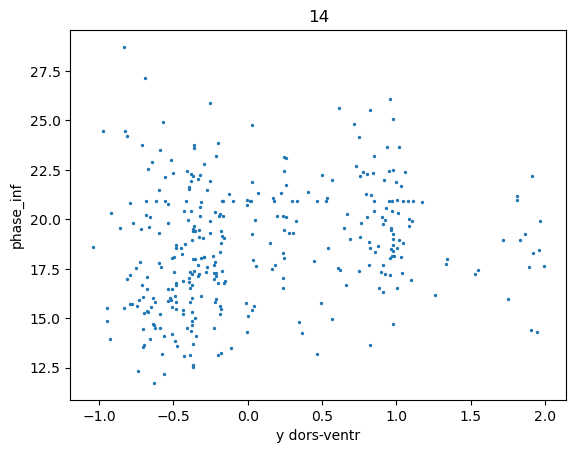

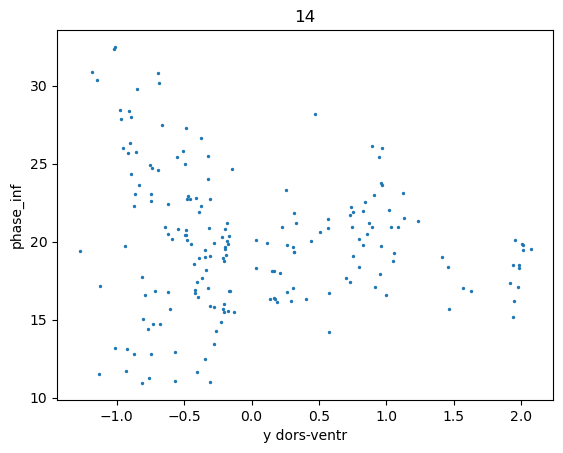

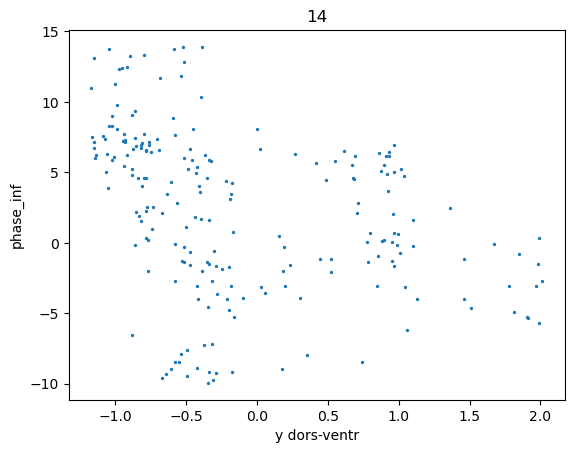

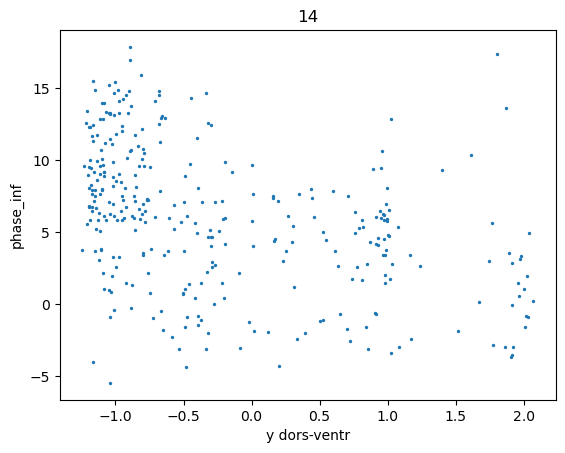

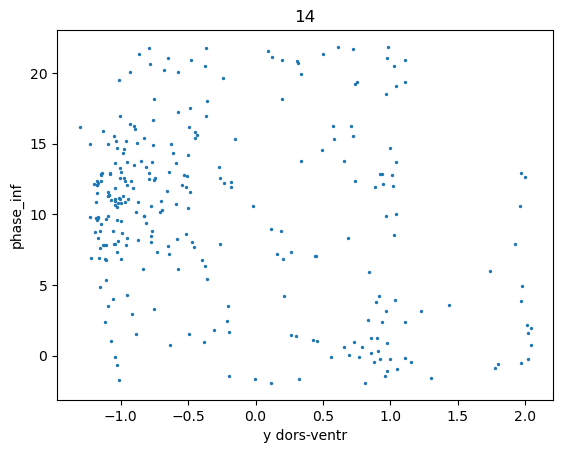

In [84]:
mask = labels == 14

for i in np.unique(labels):
    mask = labels == i
    plt.scatter(x_train[mask, 0], phase_inf[mask],  s=2)
    plt.xlabel("y dors-ventr")
    plt.ylabel("phase_inf")
    plt.title('14')
    plt.show()